  # Prediction Performance and Interpretability Assessment of Latent Feature Based Methods

  ## Imports and Constants

In [ ]:
from __future__ import annotations

from dataclasses import dataclass, field, replace
from datetime import datetime, timedelta, timezone
from functools import lru_cache
from pathlib import Path
from typing import Any, Callable, Sequence
import itertools
import json
import logging

import joblib
import nico2_lib as n2l
import numpy as np
import polars as pl
import scanpy as sc
import seaborn as sns
from anndata.typing import AnnData
from joblib import Memory
from numpy import number, str_
from numpy.typing import NDArray
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


DATA_DIR = "./data"
CACHE_DIR = "./cache"
ARTIFACT_SUBDIR = "runs"
DEFAULT_SEED = 0
DEFAULT_N_SAMPLES = 2
DEFAULT_SAMPLE_LENGTH = 20
SCHEMA_VERSION = "2.0.0"
TIMESTAMP_FORMAT = "%Y%m%dT%H%M%SZ"

if not logging.getLogger().handlers:
    logging.basicConfig(
        level=logging.INFO,
        format="%(asctime)s | %(levelname)s | %(name)s | %(message)s",
    )
logger = logging.getLogger(__name__)


NumericArray = NDArray[number]
StringArray = NDArray[str_]
LoaderFn = Callable[[str], tuple[AnnData, AnnData, str, str]]
PredictorFactory = Callable[..., n2l.pd.PredictorProtocol]
MetricFn = Callable[[NumericArray, NumericArray], float]


  ## Typed Schemas and Config

In [ ]:
@dataclass(frozen=True)
class ExperimentConfig:
    data_dir: str = DATA_DIR
    cache_dir: str = CACHE_DIR
    seed: int = DEFAULT_SEED
    n_samples: int = DEFAULT_N_SAMPLES
    sample_length: int = DEFAULT_SAMPLE_LENGTH
    artifact_dir: str = f"{CACHE_DIR}/{ARTIFACT_SUBDIR}"


@dataclass(frozen=True)
class DatasetSpec:
    name: str
    loader: LoaderFn
    metadata: dict[str, Any]


@dataclass(frozen=True)
class PredictorSpec:
    name: str
    factory: PredictorFactory
    kwargs: dict[str, Any]


@dataclass(eq=False)
class EmbeddingBlock:
    block_id: str
    celltype: str | None
    row_indices: NDArray[np.int_]
    values: NumericArray


@dataclass(eq=False)
class SampleResult:
    sample_idx: int
    prediction_scope: str
    train_idx: NDArray[np.int_]
    test_idx: NDArray[np.int_]
    embedding_blocks: list[EmbeddingBlock]
    query_reconstruction: NumericArray
    scores: dict[str, dict[str, float]] = field(default_factory=dict)


@dataclass(eq=False)
class RunSharedData:
    query_counts: NumericArray
    obs_names: NDArray[Any]
    celltypes: StringArray
    train_idxs: NDArray[np.int_]
    test_idxs: NDArray[np.int_]
    feature_names: NDArray[Any]


@dataclass(eq=False)
class RunResult:
    run_metadata: dict[str, Any]
    shared: RunSharedData
    samples: list[SampleResult]


@dataclass(eq=False)
class RunsArtifact:
    schema_version: str
    created_at_utc: str
    config: ExperimentConfig
    runs: list[RunResult]


DEFAULT_CONFIG = ExperimentConfig(
    DATA_DIR,
    CACHE_DIR,
    DEFAULT_SEED,
    DEFAULT_N_SAMPLES,
    DEFAULT_SAMPLE_LENGTH,
    f"{CACHE_DIR}/{ARTIFACT_SUBDIR}",
)


  ## Utility and Loader Helpers

In [ ]:
@lru_cache(maxsize=None)
def _get_memory(cache_dir: str) -> Memory:
    return Memory(cache_dir, verbose=0)


def _adata_dense_mut(adata: AnnData) -> None:
    if hasattr(adata.X, "toarray"):
        logger.debug("Densifying AnnData.X with shape=%s", adata.X.shape)
        adata.X = adata.X.toarray()


def _create_spatial_loader(
    query_loader: Callable[[str], AnnData],
    query_ct_key: str,
    reference_loader: Callable[[str], AnnData],
    reference_ct_key: str,
    *,
    memory: Memory,
) -> LoaderFn:
    cached_transfer = memory.cache(n2l.lt.scvi_transfer)

    def loader(data_dir: str) -> tuple[AnnData, AnnData, str, str]:
        logger.info("Loading spatial dataset from %s", data_dir)
        query = query_loader(data_dir)
        reference = reference_loader(data_dir)

        _adata_dense_mut(query)
        _adata_dense_mut(reference)

        query.obs[query_ct_key] = cached_transfer(
            query,
            reference,
            reference_ct_key,
        )
        shared_features = np.intersect1d(query.var_names, reference.var_names)
        return (
            query[:, shared_features],
            reference[:, shared_features],
            query_ct_key,
            reference_ct_key,
        )

    return loader


def _create_pseudospatial_loader(
    loader_func: Callable[[str], AnnData],
    ct_key: str,
    *,
    seed: int,
) -> LoaderFn:
    def split_loader(data_dir: str) -> tuple[AnnData, AnnData, str, str]:
        logger.info("Loading pseudospatial dataset from %s", data_dir)
        rng = np.random.default_rng(seed)
        adata = loader_func(data_dir)
        shuffled_idx = rng.permutation(adata.n_obs)
        split_idx = adata.n_obs // 2

        query = adata[shuffled_idx[:split_idx]].copy()
        reference = adata[shuffled_idx[split_idx:]].copy()

        sc.pp.highly_variable_genes(
            query,
            n_top_genes=500,
            flavor="seurat_v3",
            inplace=True,
        )
        query = query[:, query.var["highly_variable"]].copy()
        return query, reference, ct_key, ct_key

    return split_loader


  ## Registries

In [ ]:
def build_dataset_specs(config: ExperimentConfig) -> list[DatasetSpec]:
    memory = _get_memory(config.cache_dir)
    return [
        DatasetSpec(
            name="small_mouse_intestine_spatial",
            loader=_create_spatial_loader(
                n2l.dt.small_mouse_intestine_merfish,
                "cluster",
                n2l.dt.small_mouse_intestine_sc,
                "cluster",
                memory=memory,
            ),
            metadata={"organism": "mouse", "dataset_type": "spatial"},
        ),
        DatasetSpec(
            name="small_mouse_intestine_pseudospatial",
            loader=_create_pseudospatial_loader(
                n2l.dt.small_mouse_intestine_sc,
                "cluster",
                seed=config.seed,
            ),
            metadata={"organism": "mouse", "dataset_type": "pseudospatial"},
        ),
    ]


def build_predictor_specs() -> list[PredictorSpec]:
    return [
        PredictorSpec(
            name="nmf_3",
            factory=n2l.pd.NmfPredictor,
            kwargs={"n_components": 3},
        ),
        PredictorSpec(
            name="nmf_8",
            factory=n2l.pd.NmfPredictor,
            kwargs={"n_components": 8},
        ),
    ]


def aggregate_score(
    score_func: MetricFn,
    agg_func: Callable[[NDArray[np.float64]], float] = np.mean,
    axis: int = 0,
) -> MetricFn:
    def inner_func(x: NumericArray, y: NumericArray) -> float:
        x_m = np.moveaxis(x, axis, 0)
        y_m = np.moveaxis(y, axis, 0)

        scores = np.array([score_func(a, b) for a, b in zip(x_m, y_m)], dtype=float)
        scores = scores[~np.isnan(scores)]
        if scores.size == 0:
            raise ValueError("No finite metric values available to aggregate.")
        return float(agg_func(scores))

    return inner_func


def build_metric_registry() -> list[tuple[str, MetricFn]]:
    return [
        ("pearson", aggregate_score(n2l.mt.pearson_metric)),
        ("mse", aggregate_score(n2l.mt.mse_metric)),
        ("spearman", aggregate_score(n2l.mt.spearman_metric)),
        ("cosine", aggregate_score(n2l.mt.cosine_similarity_metric)),
        ("explaind_var", aggregate_score(n2l.mt.explained_variance_metric)),
        ("explained_var_v2", aggregate_score(n2l.mt.explained_variance_metric_v2)),
    ]


METRIC_REGISTRY = build_metric_registry()


  ## Core Experiment Execution

In [ ]:
def _sample_indices(
    total_features: int,
    n_samples: int,
    sample_size: int,
    rng: np.random.Generator,
) -> tuple[NDArray[np.int_], NDArray[np.int_]]:
    if sample_size < 0 or sample_size > total_features:
        raise ValueError(
            f"sample_size must be in [0, total_features], got {sample_size} for {total_features}"
        )

    indices = np.vstack([rng.permutation(total_features) for _ in range(n_samples)])
    train_idx, test_idx = np.split(indices, [sample_size], axis=1)
    return train_idx, test_idx


def _execute_run_uncached(
    dataset: tuple[AnnData, AnnData, str, str],
    predictor: n2l.pd.PredictorProtocol,
    *,
    seed: int,
    n_samples: int,
    sample_length: int,
    run_metadata: dict[str, Any],
) -> RunResult:
    query, reference, query_ct_key, reference_ct_key = dataset

    _adata_dense_mut(query)
    _adata_dense_mut(reference)

    shared_features = np.intersect1d(query.var_names, reference.var_names)
    n_features = shared_features.shape[0]
    rng = np.random.default_rng(seed)
    train_idxs, test_idxs = _sample_indices(n_features, n_samples, sample_length, rng)

    query_celltypes = query.obs[query_ct_key].to_numpy()
    reference_celltypes = reference.obs[reference_ct_key].to_numpy()
    shared_celltypes = np.intersect1d(query_celltypes, reference_celltypes)

    query_shared = query[
        query.obs[query_ct_key].isin(shared_celltypes), shared_features
    ]
    reference_shared = reference[
        reference.obs[reference_ct_key].isin(shared_celltypes), shared_features
    ]

    shared = RunSharedData(
        query_counts=query_shared.X,
        obs_names=query_shared.obs_names.to_numpy(copy=False),
        celltypes=query_shared.obs[query_ct_key].to_numpy(),
        train_idxs=train_idxs,
        test_idxs=test_idxs,
        feature_names=query_shared.var_names.to_numpy(copy=False),
    )
    n_obs = int(query_shared.X.shape[0])

    samples: list[SampleResult] = []

    global_model = predictor.fit(reference_shared.X)
    for sample_idx, (train_idx, test_idx) in enumerate(zip(train_idxs, test_idxs)):
        embedding, prediction = global_model.predict(
            query_shared[:, train_idx].X, train_idx
        )
        embedding_blocks = [
            EmbeddingBlock(
                block_id="global",
                celltype=None,
                row_indices=np.arange(n_obs, dtype=np.int_),
                values=embedding,
            )
        ]
        samples.append(
            SampleResult(
                sample_idx=sample_idx,
                prediction_scope="global",
                train_idx=train_idx,
                test_idx=test_idx,
                embedding_blocks=embedding_blocks,
                query_reconstruction=prediction,
            )
        )

    celltype_models: list[tuple[str, Any, AnnData, NDArray[np.int_]]] = []
    query_shared_celltypes = query_shared.obs[query_ct_key].to_numpy()
    reference_shared_celltypes = reference_shared.obs[reference_ct_key].to_numpy()

    for celltype in shared_celltypes:
        reference_mask = reference_shared_celltypes == celltype
        query_mask = query_shared_celltypes == celltype
        reference_celltype = reference_shared[reference_mask]
        query_celltype = query_shared[query_mask]
        model = predictor.fit(reference_celltype.X)
        query_row_indices = np.flatnonzero(query_mask)
        celltype_models.append((celltype, model, query_celltype, query_row_indices))

    for sample_idx, (train_idx, test_idx) in enumerate(zip(train_idxs, test_idxs)):
        embedding_blocks: list[EmbeddingBlock] = []
        reconstruction_parts = []
        query_row_indices_parts = []

        for celltype, model, query_celltype, query_row_indices in celltype_models:
            embedding, prediction = model.predict(
                query_celltype[:, train_idx].X, train_idx
            )
            embedding_blocks.append(
                EmbeddingBlock(
                    block_id=f"celltype:{celltype}",
                    celltype=str(celltype),
                    row_indices=query_row_indices,
                    values=embedding,
                )
            )
            reconstruction_parts.append(prediction)
            query_row_indices_parts.append(query_row_indices)

        if not embedding_blocks:
            continue

        ordered_idx = np.argsort(np.concatenate(query_row_indices_parts))
        query_reconstruction = np.concatenate(reconstruction_parts, axis=0)[ordered_idx]

        samples.append(
            SampleResult(
                sample_idx=sample_idx,
                prediction_scope="celltype",
                train_idx=train_idx,
                test_idx=test_idx,
                embedding_blocks=embedding_blocks,
                query_reconstruction=query_reconstruction,
            )
        )

    return RunResult(run_metadata=run_metadata, shared=shared, samples=samples)


def execute_run(
    dataset_spec: DatasetSpec,
    predictor_spec: PredictorSpec,
    config: ExperimentConfig,
) -> RunResult:
    dataset = dataset_spec.loader(config.data_dir)
    predictor = predictor_spec.factory(**predictor_spec.kwargs)

    run_metadata = {
        "dataset_name": dataset_spec.name,
        "predictor_name": predictor_spec.name,
        **dataset_spec.metadata,
        **predictor_spec.kwargs,
        "seed": config.seed,
        "n_samples": config.n_samples,
        "sample_length": config.sample_length,
    }

    cached_execute = _get_memory(config.cache_dir).cache(_execute_run_uncached)
    return cached_execute(
        dataset,
        predictor,
        seed=config.seed,
        n_samples=config.n_samples,
        sample_length=config.sample_length,
        run_metadata=run_metadata,
    )


  ## Scoring

In [ ]:
def compute_score(
    query: NumericArray,
    query_reconstruction: NumericArray,
    celltypes: StringArray,
    metric_registry: Sequence[tuple[str, MetricFn]],
) -> dict[str, dict[str, float]]:
    if query.shape[0] != query_reconstruction.shape[0]:
        raise ValueError(
            "query and query_reconstruction must have matching n_obs: "
            f"{query.shape[0]} != {query_reconstruction.shape[0]}"
        )
    if query.shape[0] != celltypes.shape[0]:
        raise ValueError(
            f"celltypes length must match n_obs: {celltypes.shape[0]} != {query.shape[0]}"
        )

    unique_celltypes = np.unique(celltypes)
    result: dict[str, dict[str, float]] = {}

    for metric_name, metric_func in metric_registry:
        scores: list[float] = []
        weights: list[int] = []

        for ct in unique_celltypes:
            mask = celltypes == ct
            n = int(mask.sum())
            if n == 0:
                continue
            scores.append(float(metric_func(query[mask], query_reconstruction[mask])))
            weights.append(n)

        if not scores:
            raise ValueError("No celltypes found to score (empty input).")

        result[metric_name] = {
            "weighted": float(np.average(scores, weights=weights)),
            "macro": float(np.mean(scores)),
        }

    return result


def score_run(
    run: RunResult,
    metric_registry: Sequence[tuple[str, MetricFn]],
) -> RunResult:
    scored_samples: list[SampleResult] = []

    for sample in run.samples:
        scores = compute_score(
            run.shared.query_counts[:, sample.test_idx],
            sample.query_reconstruction[:, sample.test_idx],
            run.shared.celltypes,
            metric_registry,
        )
        scored_samples.append(replace(sample, scores=scores))

    return RunResult(
        run_metadata=dict(run.run_metadata),
        shared=run.shared,
        samples=scored_samples,
    )


  ## Persistence (Artifacts)

In [ ]:
def _utc_timestamp() -> str:
    return datetime.now(timezone.utc).strftime(TIMESTAMP_FORMAT)


def _parse_utc_timestamp(value: str) -> datetime:
    return datetime.strptime(value, TIMESTAMP_FORMAT).replace(tzinfo=timezone.utc)


def _artifact_path(artifact_dir: Path, timestamp: str) -> Path:
    return artifact_dir / f"runs_{timestamp}.joblib"


def _next_available_timestamp(artifact_dir: Path, base_timestamp: str) -> str:
    dt = _parse_utc_timestamp(base_timestamp)
    while _artifact_path(artifact_dir, dt.strftime(TIMESTAMP_FORMAT)).exists():
        dt += timedelta(seconds=1)
    return dt.strftime(TIMESTAMP_FORMAT)


def _write_json_atomic(path: Path, payload: dict[str, Any]) -> None:
    temp_path = path.with_suffix(f"{path.suffix}.tmp")
    with temp_path.open("w", encoding="utf-8") as fh:
        json.dump(payload, fh, indent=2)
    temp_path.replace(path)


def save_runs_artifact(artifact: RunsArtifact) -> Path:
    artifact_dir = Path(artifact.config.artifact_dir)
    artifact_dir.mkdir(parents=True, exist_ok=True)

    base_timestamp = artifact.created_at_utc or _utc_timestamp()
    timestamp = _next_available_timestamp(artifact_dir, base_timestamp)
    artifact.created_at_utc = timestamp

    target_path = _artifact_path(artifact_dir, timestamp)
    temp_path = target_path.with_suffix(f"{target_path.suffix}.tmp")

    joblib.dump(artifact, temp_path, compress=3)
    temp_path.replace(target_path)

    latest_pointer = {
        "schema_version": artifact.schema_version,
        "latest_artifact": target_path.name,
        "updated_at_utc": _utc_timestamp(),
    }
    _write_json_atomic(artifact_dir / "latest.json", latest_pointer)
    return target_path


def _resolve_latest_artifact_path(artifact_dir: Path) -> Path:
    latest_path = artifact_dir / "latest.json"
    if not latest_path.exists():
        raise FileNotFoundError(
            f"No latest artifact pointer found at {latest_path}. "
            "Run run_pipeline(...) first or pass an explicit artifact path."
        )

    try:
        payload = json.loads(latest_path.read_text(encoding="utf-8"))
        latest_name = payload["latest_artifact"]
    except (json.JSONDecodeError, KeyError) as exc:
        raise RuntimeError(f"Failed to parse artifact pointer: {latest_path}") from exc

    artifact_path = artifact_dir / latest_name
    if not artifact_path.exists():
        raise FileNotFoundError(
            f"latest.json points to missing artifact: {artifact_path}. "
            "Run pipeline again or fix latest.json."
        )
    return artifact_path


def list_runs_artifacts(artifact_dir: Path | None = None) -> list[Path]:
    target_dir = (
        Path(DEFAULT_CONFIG.artifact_dir)
        if artifact_dir is None
        else Path(artifact_dir)
    )
    if not target_dir.exists():
        return []
    return sorted(target_dir.glob("runs_*.joblib"))


def load_runs_artifact(path: Path | None = None) -> RunsArtifact:
    if path is None:
        path = _resolve_latest_artifact_path(Path(DEFAULT_CONFIG.artifact_dir))

    path = Path(path)
    if not path.exists():
        raise FileNotFoundError(f"Runs artifact not found: {path}")

    try:
        artifact = joblib.load(path)
    except Exception as exc:  # noqa: BLE001
        raise RuntimeError(f"Failed to load runs artifact from {path}") from exc

    if not isinstance(artifact, RunsArtifact):
        raise TypeError(
            f"Artifact at {path} has unexpected type {type(artifact).__name__}; "
            "expected RunsArtifact"
        )
    if artifact.schema_version != SCHEMA_VERSION:
        raise RuntimeError(
            "Unsupported artifact schema version: "
            f"{artifact.schema_version!r}; expected {SCHEMA_VERSION!r}."
        )
    return artifact


def load_pipeline_data(path: Path | None = None) -> RunsArtifact:
    return load_runs_artifact(path=path)


  ## Pipeline Entrypoints

In [ ]:
def run_pipeline(config: ExperimentConfig) -> RunsArtifact:
    dataset_specs = build_dataset_specs(config)
    predictor_specs = build_predictor_specs()
    runs: list[RunResult] = []

    total = len(dataset_specs) * len(predictor_specs)
    for dataset_spec, predictor_spec in tqdm(
        itertools.product(dataset_specs, predictor_specs),
        total=total,
        desc="Running experiments",
    ):
        run = execute_run(dataset_spec, predictor_spec, config)
        scored_run = score_run(run, METRIC_REGISTRY)
        runs.append(scored_run)

    artifact = RunsArtifact(
        schema_version=SCHEMA_VERSION,
        created_at_utc=_utc_timestamp(),
        config=config,
        runs=runs,
    )
    artifact_path = save_runs_artifact(artifact)
    logger.info("Saved runs artifact to %s", artifact_path)
    return artifact


  ## DataFrame and Plotting

In [ ]:
def artifact_to_score_frame(artifact: RunsArtifact) -> pl.DataFrame:
    df_rows: list[dict[str, Any]] = []

    for run in artifact.runs:
        for sample in run.samples:
            base = {
                "dataset_name": run.run_metadata["dataset_name"],
                "predictor_name": run.run_metadata["predictor_name"],
                "prediction_scope": sample.prediction_scope,
                "sample_idx": sample.sample_idx,
            }
            for aggregation_type in ("weighted", "macro"):
                row = base | {"aggregation_type": aggregation_type}
                row |= {
                    metric_name: score_by_agg[aggregation_type]
                    for metric_name, score_by_agg in sample.scores.items()
                }
                df_rows.append(row)

    return pl.DataFrame(df_rows)


def plot_reconstruction_scores(df: pl.DataFrame) -> None:
    if df.height == 0:
        raise ValueError("Score DataFrame is empty; nothing to plot.")

    id_cols = [
        "dataset_name",
        "predictor_name",
        "prediction_scope",
        "sample_idx",
        "aggregation_type",
    ]
    metric_cols = [c for c in df.columns if c not in id_cols]

    plot_df = df.to_pandas().melt(
        id_vars=id_cols,
        value_vars=metric_cols,
        var_name="metric_name",
        value_name="metric_score",
    )

    for dataset_name in plot_df["dataset_name"].drop_duplicates():
        dataset_plot_df = plot_df[plot_df["dataset_name"] == dataset_name]

        g = sns.catplot(
            data=dataset_plot_df,
            kind="box",
            x="predictor_name",
            y="metric_score",
            hue="prediction_scope",
            row="aggregation_type",
            col="metric_name",
            sharey=False,
            height=3.5,
            aspect=1.25,
            margin_titles=True,
        )

        g.fig.suptitle(f"dataset_name = {dataset_name}", y=1.02)
        for ax in g.axes.flat:
            ax.tick_params(axis="x", rotation=45)
            if ax.get_title().endswith("pearson"):
                ax.set_ylim(0, 1)
        g.tight_layout()


  ## Notebook Usage Flow

In [ ]:
config = ExperimentConfig()
artifact = run_pipeline(config)


In [15]:
# or load artifact via load_pipeline_data(path/to/artifact), no path loading the last run
artifact = load_runs_artifact()

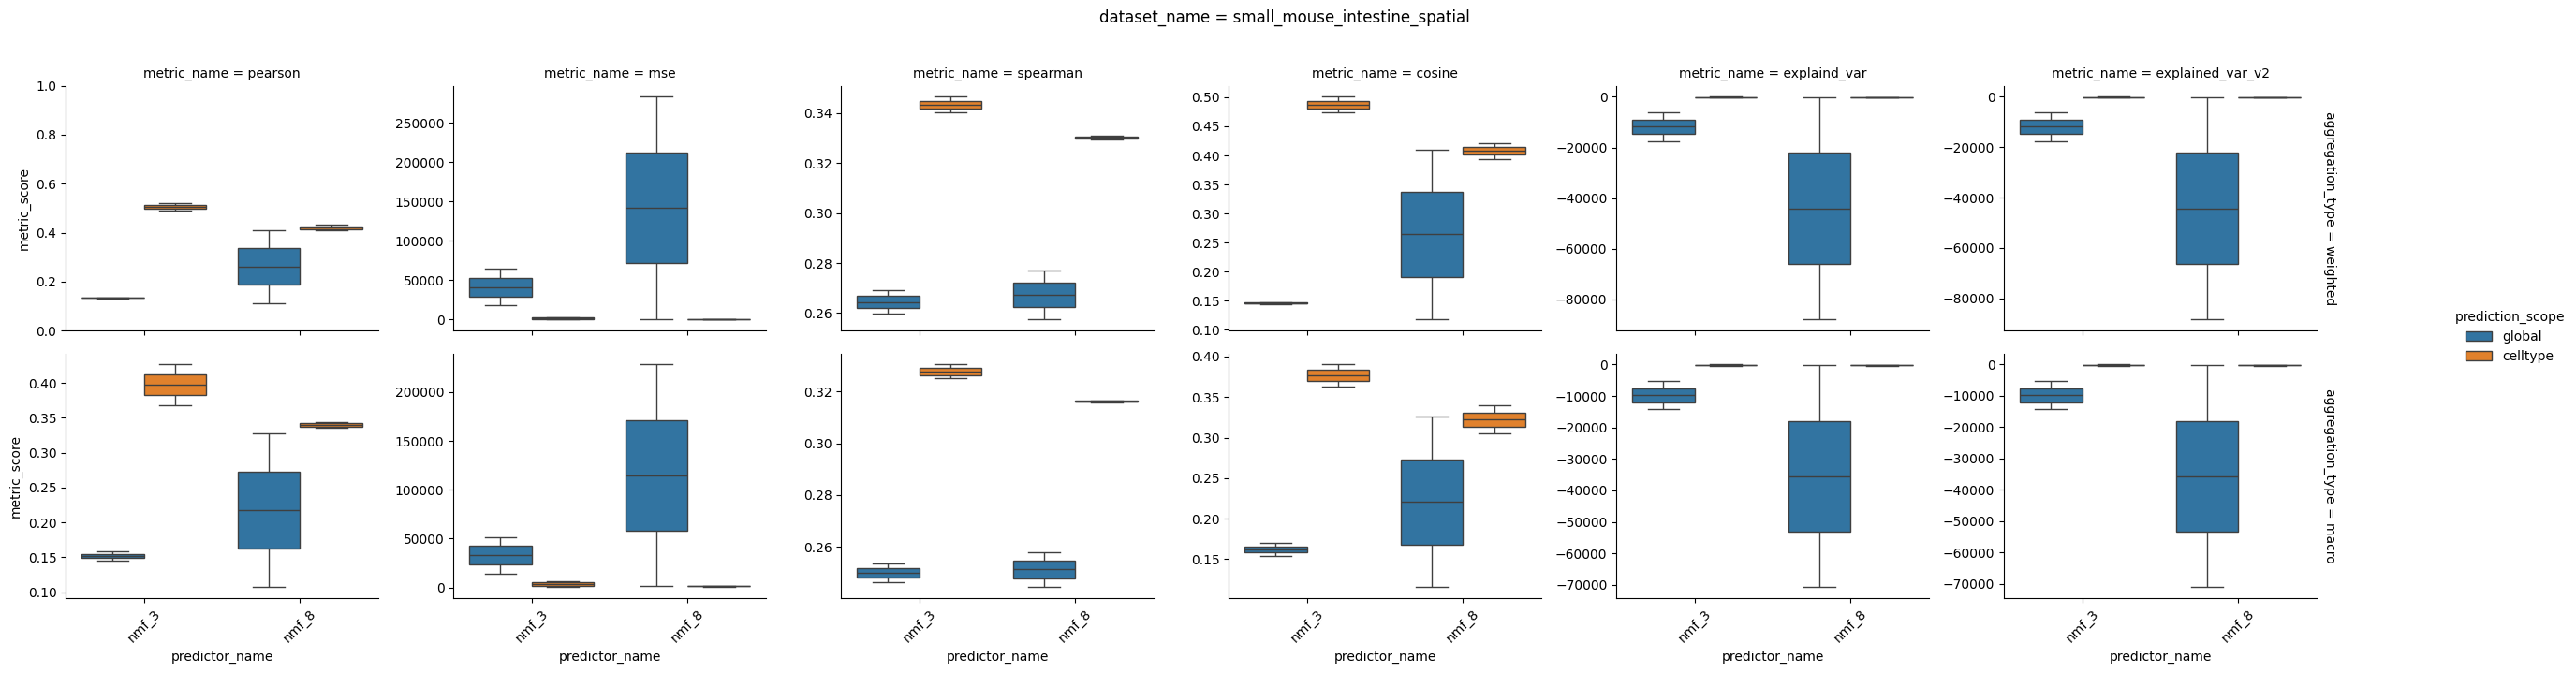

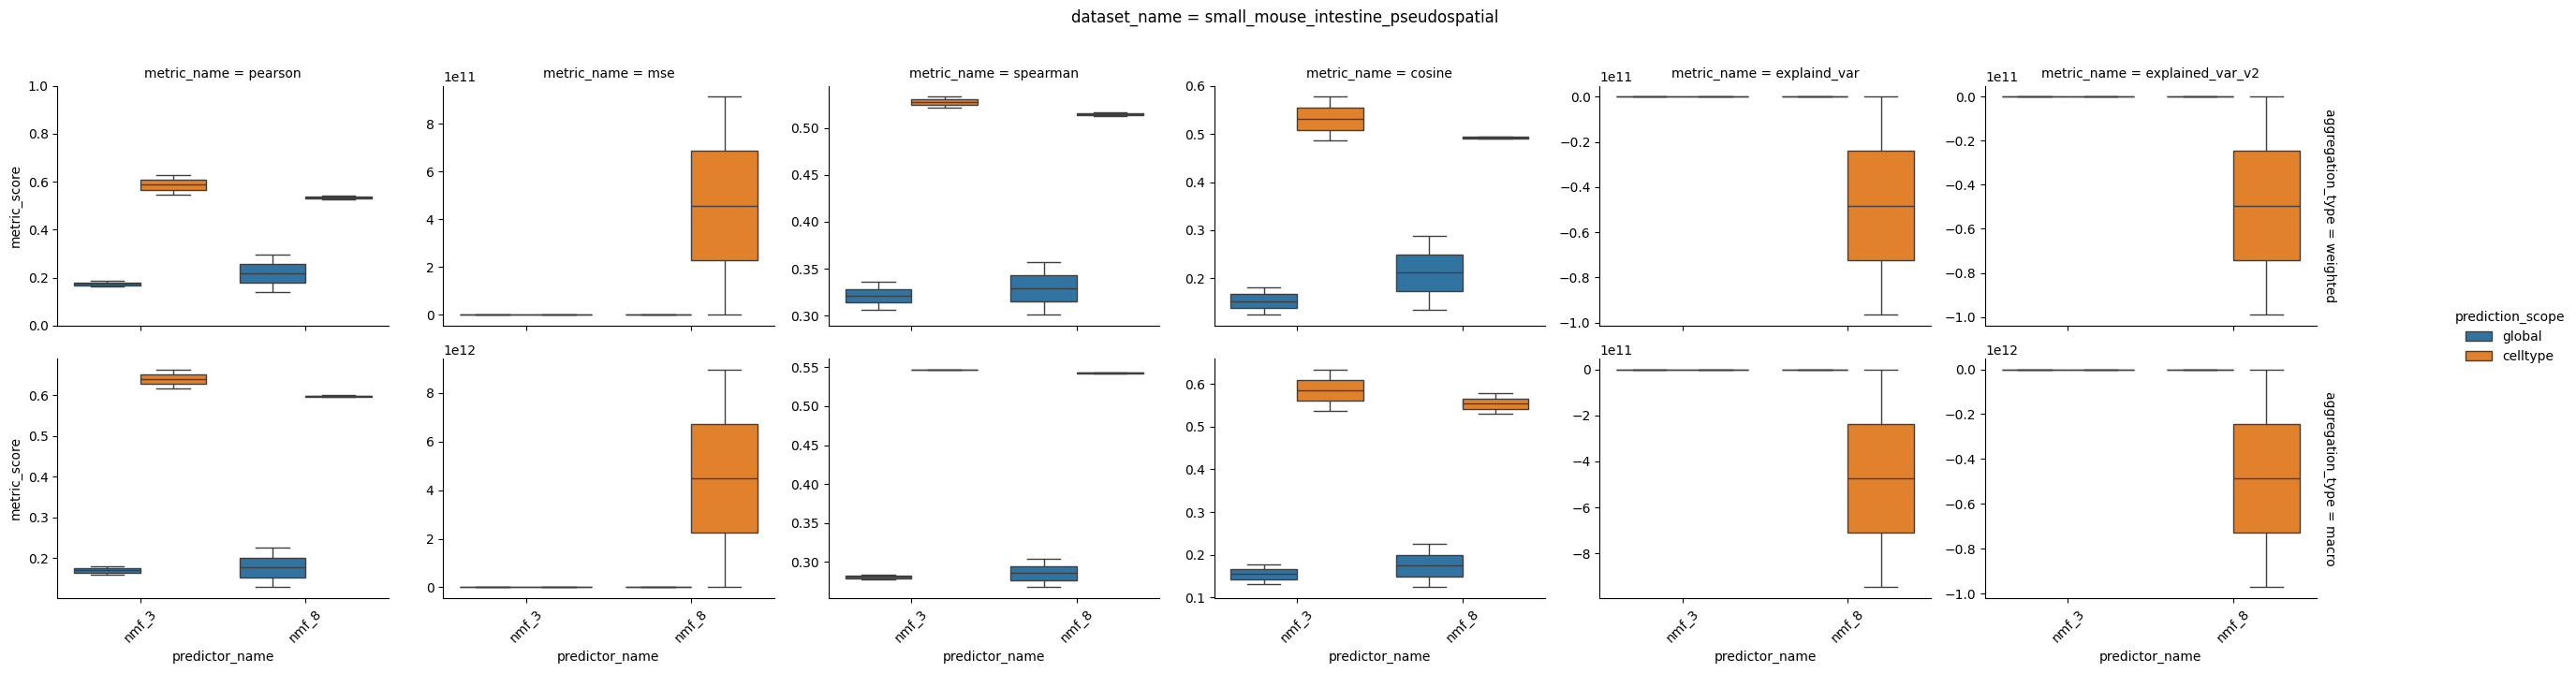

In [16]:
df = artifact_to_score_frame(artifact)

plot_reconstruction_scores(df)

  ### Model Embeddings

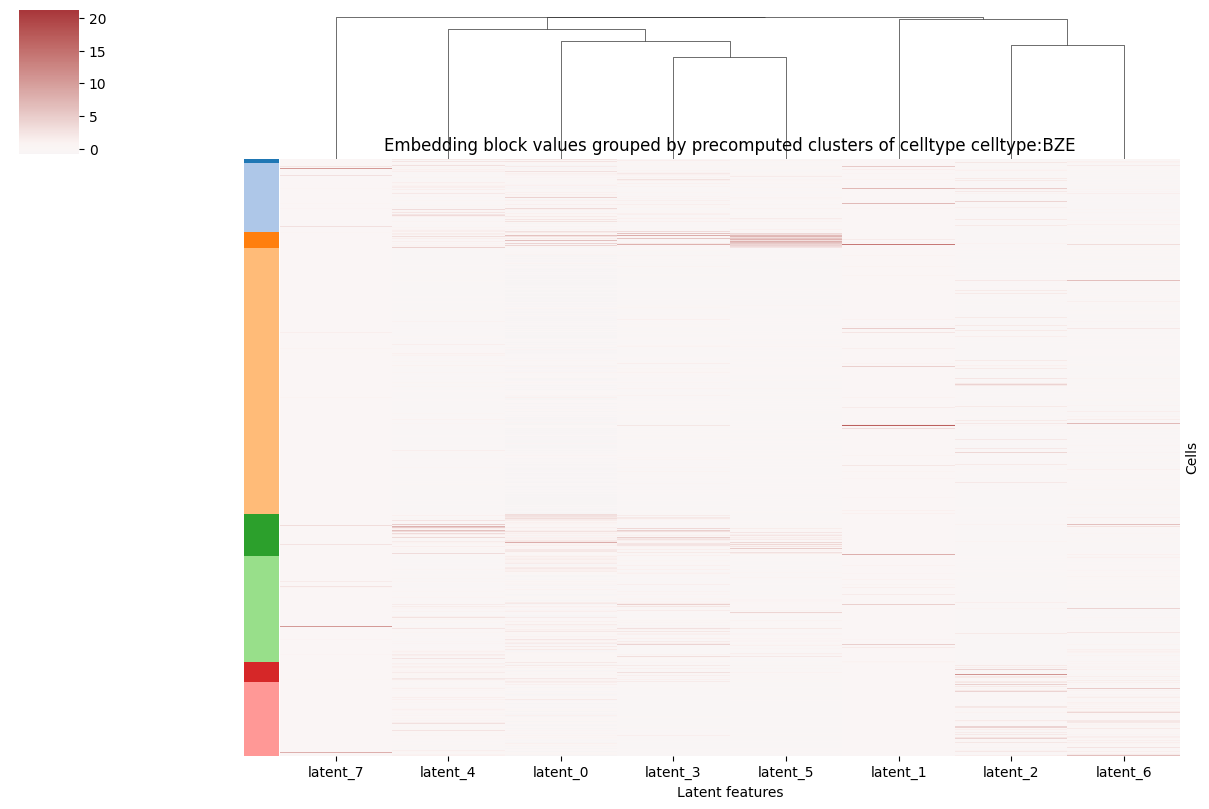

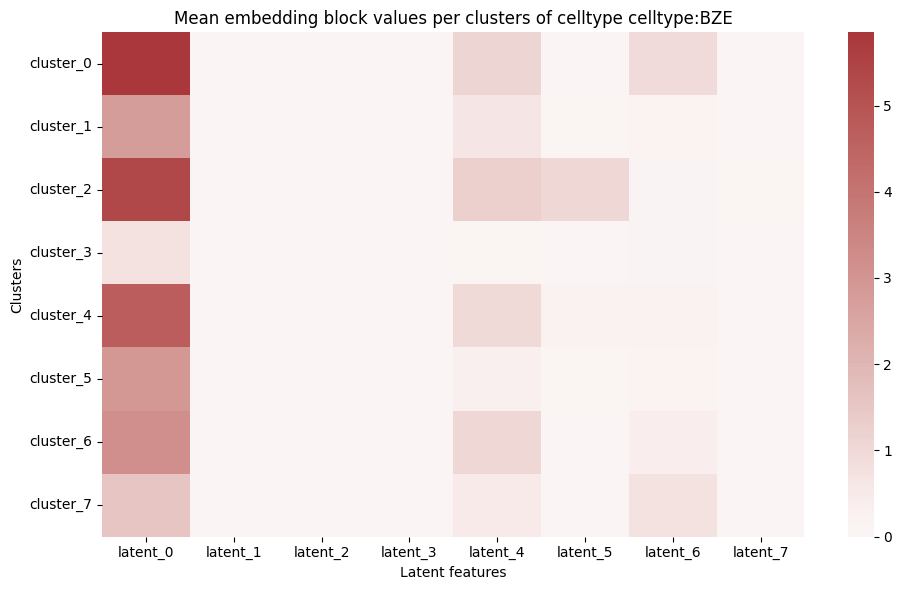

In [54]:
runs = artifact.runs
run = runs[1]
query_counts = run.shared.query_counts
celltypes = run.shared.celltypes
sample = run.samples[3]
embedding_block = sample.embedding_blocks[0]
row_indices = embedding_block.row_indices
embedding_block_values = embedding_block.values
query_counts_block = query_counts[row_indices]
n_latent_features = embedding_block_values.shape[1]
clusters = KMeans(n_clusters=n_latent_features).fit_predict(
    PCA(n_components=25).fit_transform(query_counts_block)
)
celltype = embedding_block.block_id



unique_clusters = np.unique(clusters)
n_latent_features = embedding_block_values.shape[1]
palette = sns.color_palette("tab20", n_colors=max(1, len(unique_clusters)))
cluster_to_color = {
    cluster_id: palette[idx % len(palette)]
    for idx, cluster_id in enumerate(unique_clusters)
}

ordered_idx = np.argsort(clusters, kind="stable")
ordered_values = embedding_block_values[ordered_idx]
ordered_clusters = clusters[ordered_idx]
row_colors = [cluster_to_color[cluster_id] for cluster_id in ordered_clusters]

grid = sns.clustermap(
    ordered_values,
    row_cluster=False,
    col_cluster=True,
    row_colors=row_colors,
    z_score=1,
    cmap="vlag",
    center=0,
    xticklabels=[f"latent_{i}" for i in range(n_latent_features)],
    yticklabels=False,
    figsize=(12, 8),
)
grid.ax_heatmap.set_title(f"Embedding block values grouped by precomputed clusters of celltype {celltype}")
grid.ax_heatmap.set_xlabel("Latent features")
grid.ax_heatmap.set_ylabel("Cells")

cluster_means = np.vstack(
    [embedding_block_values[clusters == cluster_id].mean(axis=0) for cluster_id in unique_clusters]
)
plt.figure(figsize=(10, 6))
sns.heatmap(
    cluster_means,
    cmap="vlag",
    center=0,
    xticklabels=[f"latent_{i}" for i in range(n_latent_features)],
    yticklabels=[f"cluster_{cluster_id}" for cluster_id in unique_clusters],
)
plt.title(f"Mean embedding block values per clusters of celltype {celltype}")
plt.xlabel("Latent features")
plt.ylabel("Clusters")
plt.tight_layout()